In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 회귀 실습 - 자전거 대여 수요 예측

- Kaggle Bike Sharing Demand 예측 경연 대회
- https://www.kaggle.com/c/bike-sharing-demand/data
- 2011.01~2012.12 날짜/시간(1시간 간격), 기온 습도, 풍속, 자전거 대여 횟수

- datetime: hourly date + timestamp
- season: 1=봄, 2=여름, 3=가을, 4=겨울
- holiday: 1=주말을 제외한 국경일 등의 휴일, 0=휴일이 아닌 날
- workingday: 1=주말 및 휴일이 아닌 주중, 0=주말 및 휴일
- weather:
    - 1=맑음, 약간 구름 낀 흐림
    - 2=안개, 안개 + 흐림
    - 3=가벼운 눈, 가벼운 비 + 천둥
    - 4=심한 눈/비, 천둥/번개
- temp: 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity: 상대습도
- windspeed: 풍속
- casual: 사전에 등록되지 않은 사용자가 대여한 횟수
- registered: 사전에 등록된 사용자가 대여한 횟수
- count: 대여 횟수

### 데이터 탐색

In [2]:
bike = pd.read_csv('data/bike_train.csv')
bike.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [3]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### 데이터 클렌징 및 가공

**datetime 컬럼을 datetime 타입으로 변경하고 년,월,일,시 컬럼으로 추출**

In [4]:
bike2 = bike.copy()
bike2['datetime'] = pd.to_datetime(bike2['datetime'])
bike2['year'] = bike2['datetime'].dt.year
bike2['month'] = bike2['datetime'].dt.month
bike2['day'] = bike2['datetime'].dt.day
bike2['hour'] = bike2['datetime'].dt.hour
bike2.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


**피처 삭제**
- 상관성이 있는 컬럼들 삭제 : 'datetime','casual','registered'

In [5]:
bike2.drop(['datetime','casual','registered'], axis=1, inplace= True)
bike2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int32  
 10  month       10886 non-null  int32  
 11  day         10886 non-null  int32  
 12  hour        10886 non-null  int32  
dtypes: float64(3), int32(4), int64(6)
memory usage: 935.6 KB


#### 변수별 기술통계량

In [30]:
def data_describe(df):
    desc = df.describe().T
    skew = []
    kurtosis = []
    null = []
    for ftr in df.columns:
        skew.append(df[ftr].skew())
        kurtosis.append(df[ftr].kurtosis())
        null.append(df[ftr].isna().sum())
    desc['skewness'] = skew
    desc['kurtosis'] = kurtosis
    desc['n_null'] = null
    return desc

In [31]:
desc_bike = data_describe(bike2)
desc_bike

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,n_null
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000,-0.007076,-1.355661,0
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000,5.660517,30.046975,0
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000,-0.776163,-1.397828,0
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000,1.243484,0.395533,0
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000,0.003691,-0.914530,0
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550,-0.102560,-0.850076,0
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000,-0.086335,-0.759818,0
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969,0.588767,0.630133,0
count,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000,1.242066,1.300093,0
year,10886.0,2011.501929,0.500019,2011.00,2011.0000,2012.000,2012.0000,2012.0000,-0.007717,-2.000308,0


#### 변수별 빈도표

In [43]:
int_ftrs = bike2.select_dtypes(include='int').columns.difference(['humidity','count'])

for ftr in int_ftrs:
    print(bike2[ftr].value_counts().sort_index())
    print()

day
1     575
2     573
3     573
4     574
5     575
6     572
7     574
8     574
9     575
10    572
11    568
12    573
13    574
14    574
15    574
16    574
17    575
18    563
19    574
Name: count, dtype: int64

holiday
0    10575
1      311
Name: count, dtype: int64

hour
0     455
1     454
2     448
3     433
4     442
5     452
6     455
7     455
8     455
9     455
10    455
11    455
12    456
13    456
14    456
15    456
16    456
17    456
18    456
19    456
20    456
21    456
22    456
23    456
Name: count, dtype: int64

month
1     884
2     901
3     901
4     909
5     912
6     912
7     912
8     912
9     909
10    911
11    911
12    912
Name: count, dtype: int64

season
1    2686
2    2733
3    2733
4    2734
Name: count, dtype: int64

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64

workingday
0    3474
1    7412
Name: count, dtype: int64

year
2011    5422
2012    5464
Name: count, dtype: int64



#### 데이터 시각화

- 변수별(정수형/범주형) barplot

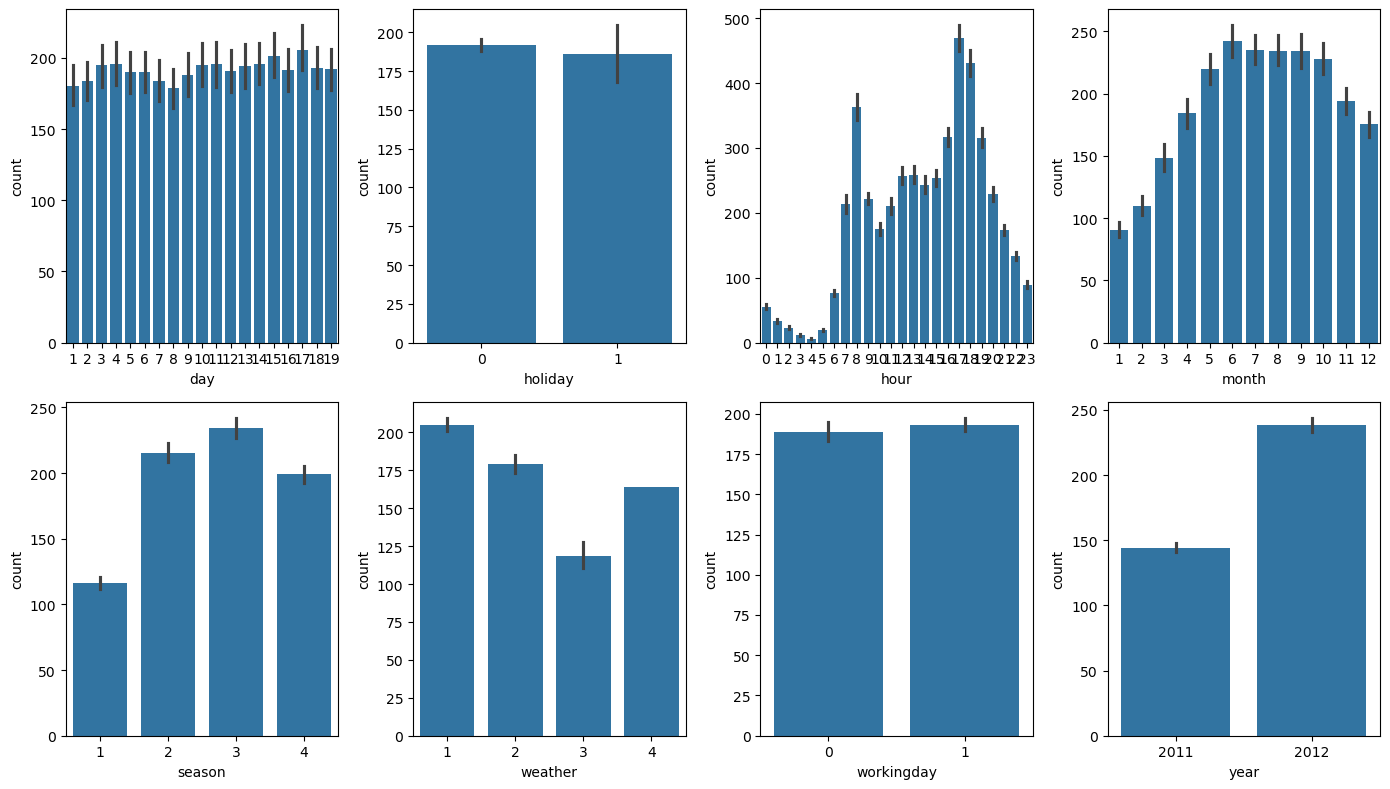

In [48]:
bar_ftrs = bike2.select_dtypes(include='int').columns.difference(['humidity','count'])

fig, ax = plt.subplots(figsize=(14,8), nrows=2, ncols=4)
for i, ftr in enumerate(bar_ftrs):
    row, col = i//4, i%4
    sns.barplot(data=bike2, x= ftr, y='count', ax=ax[row][col])
plt.tight_layout()
plt.show()

- 수치형 변수들의 histplot

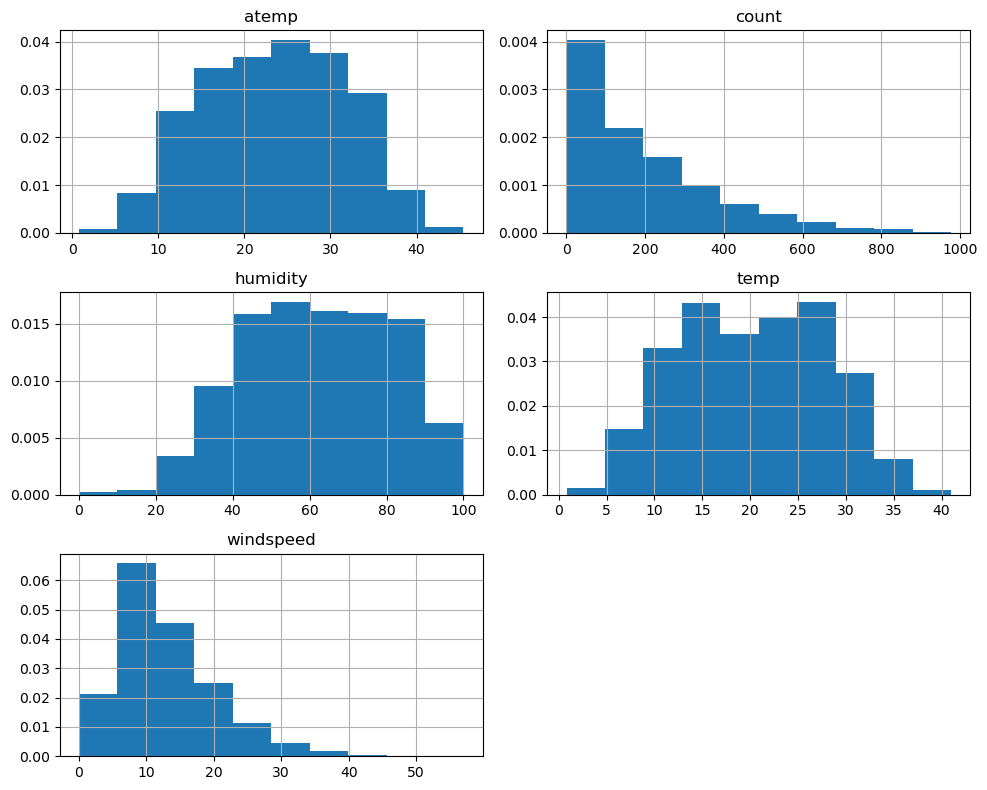

In [50]:
hist_ftrs = bike2.select_dtypes(include='float').columns.union(['humidity','count'])
bike2[hist_ftrs].hist(figsize=(10,8), density= True)
plt.tight_layout()
plt.show()

- count변수와의 regplot

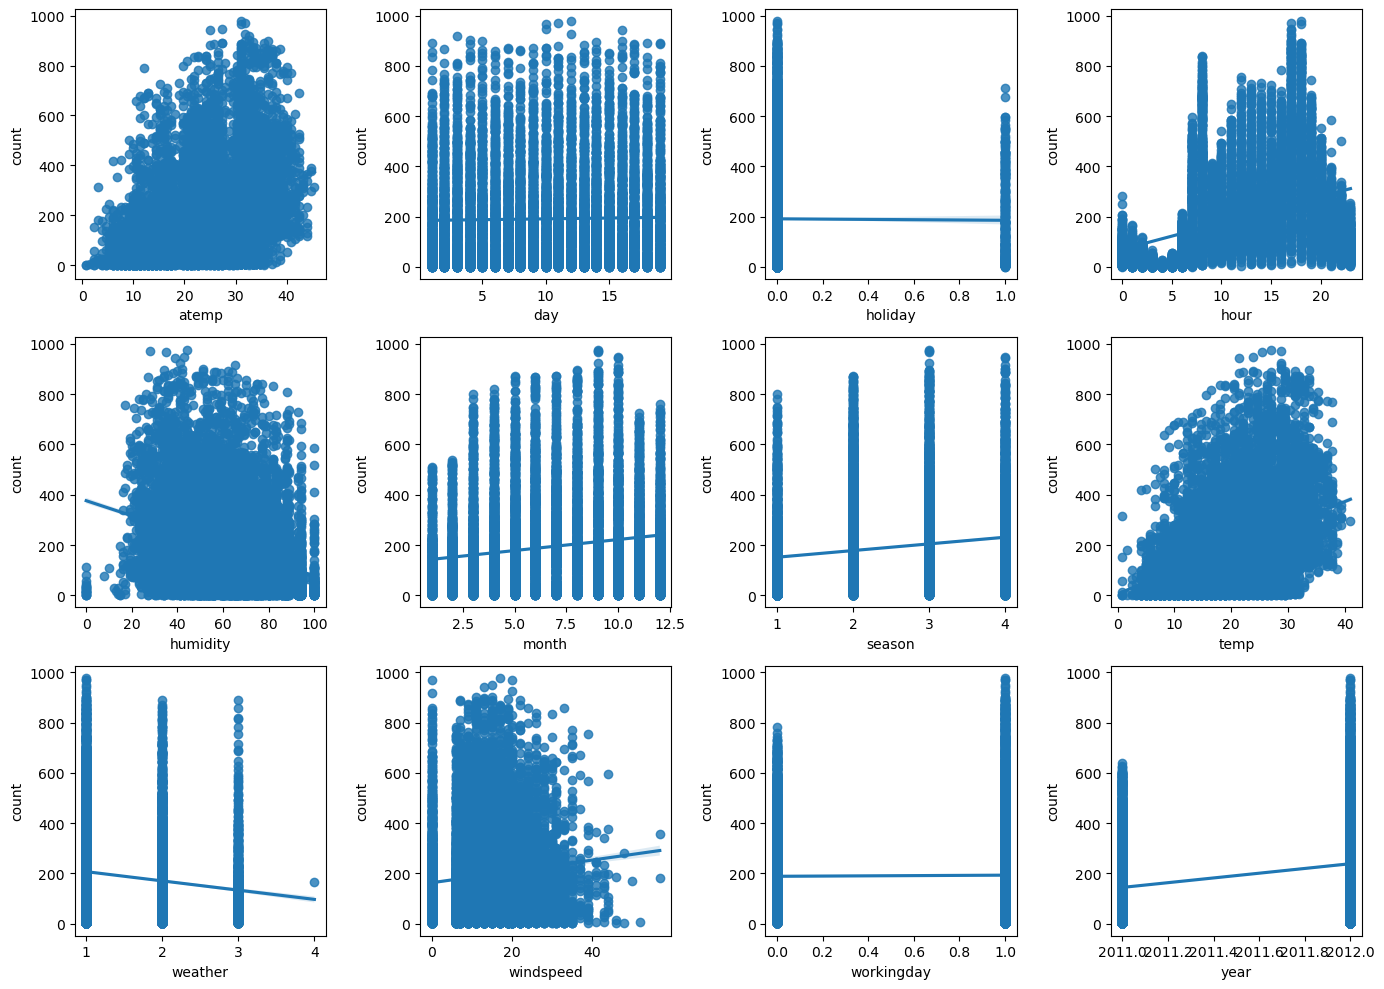

In [51]:
reg_ftrs = bike2.columns.difference(['count'])
fig, ax = plt.subplots(figsize=(14,10), nrows=3, ncols=4)
for i, ftr in enumerate(reg_ftrs):
    row, col = i//4, i%4
    sns.regplot(data=bike2, x= ftr, y='count', ax=ax[row][col])
plt.tight_layout()
plt.show()

- 상관계수 시각화

In [52]:
def correlation_heatmap(df):
    corr = df.corr()
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    mask = np.zeros_like(corr, dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
                linewidths=.5, fmt='.2f', annot_kws={'size':8})
    plt.show()
    return corr

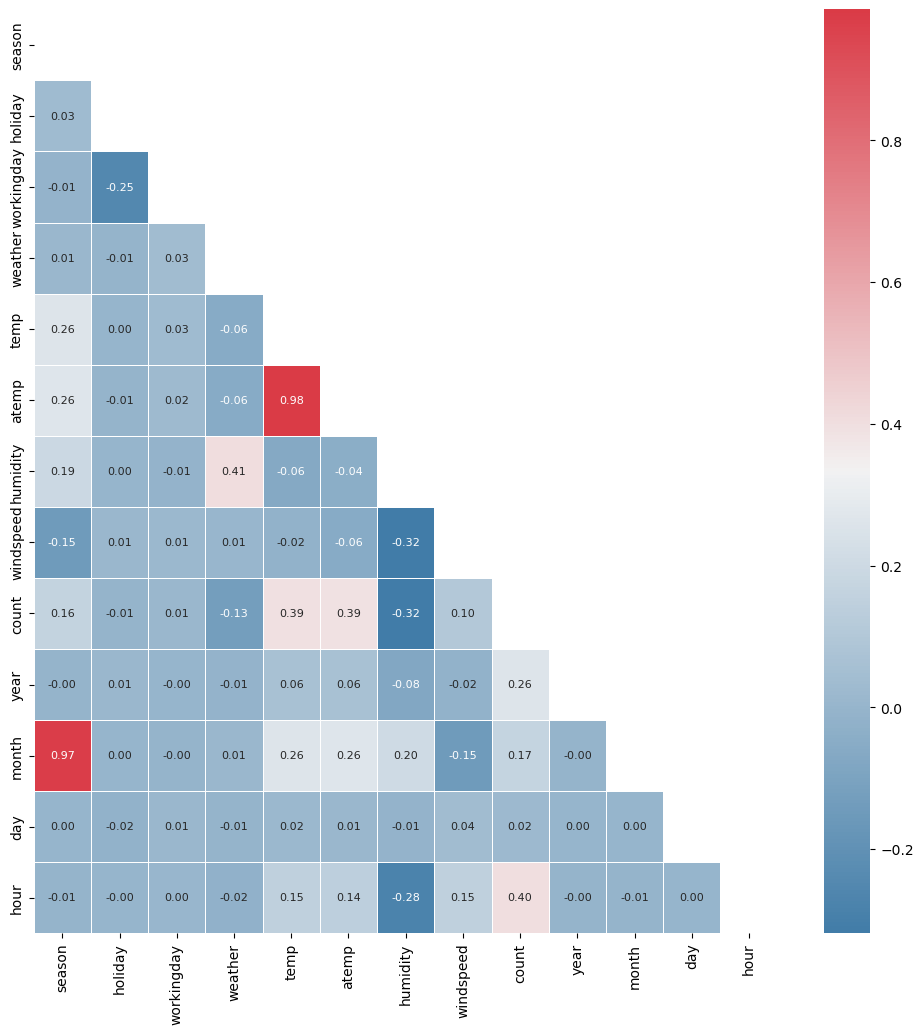

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439,-0.004797,0.971524,0.001729,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393,0.012021,0.001731,-0.015877,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594,-0.002482,-0.003394,0.009829,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655,-0.012548,0.012144,-0.007890,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.061226,0.257589,0.015551,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.058540,0.264173,0.011866,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,-0.078606,0.204537,-0.011335,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369,-0.015221,-0.150192,0.036157,0.146631
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000,0.260403,0.166862,0.019826,0.400601
year,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,0.260403,1.000000,-0.004932,0.001800,-0.004234


In [53]:
correlation_heatmap(bike2)

- count변수와 피처들간의 상관계수와 유의성 검정

In [55]:
from scipy import stats

def pearson_corr(df, target_name):
    ftr_names = df.columns.difference([target_name])
    coef_list = []
    p_list = []
    for col in ftr_names:
        coef, p = stats.pearsonr(df[target_name], df[col])
        coef_list.append(np.round(coef, 4))
        p_list.append(p)
    
    corr_df = pd.DataFrame({'pearson_coef': coef_list, 'p_value': p_list}, 
                 index=ftr_names).sort_values('pearson_coef', ascending=False)
    return corr_df

In [57]:
pearson_corr(bike2, target_name='count')

,pearson_coef,p_value
hour,0.4006,0.000000e+00
temp,0.3945,0.000000e+00
atemp,0.3898,0.000000e+00
year,0.2604,3.242014e-168
month,0.1669,8.342867e-69
season,0.1634,4.758934e-66
windspeed,0.1014,2.898407e-26
day,0.0198,3.859228e-02
workingday,0.0116,2.264480e-01
holiday,-0.0054,5.736924e-01


**회귀모델 성능평가 함수 작성**

In [6]:
def reg_model_cv_training(model, x, y, cv=5, scoring='neg_mean_squared_error', alpha=None):
    neg_mse = cross_val_score(model, x,y, cv= cv, scoring= scoring)
    rmse = np.sqrt(neg_mse*(-1))
    avg_rmse = np.mean(rmse)
    if alpha:
        text = 'alpha='+ str(alpha)
    else:
        text= ''
    print(f'-- {model.__class__.__name__} {text}의 {cv}폴드 교차검증 --')
    print(f'RMSE: {np.round(rmse,3)}, AVG_RMSE: {np.round(avg_rmse,3)}')
    return rmse, avg_rmse

### (1) 피처 클렌징 후 선형회귀 모델 학습/예측/평가

In [7]:
def fittormse(x,y, model):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    rmse, avg_rmse = reg_model_cv_training(model, x, y, cv=5, scoring='neg_mean_squared_error')
    return rmse, avg_rmse

**실제 대여횟수와 예측 대여횟수 비교**

In [60]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

x = bike2.drop('count', axis=1)
y = bike2['count']
lr = LinearRegression()

rmse, avg_rmse = fittormse(x,y,lr)

-- LinearRegression 의 5폴드 교차검증 --
RMSE: [103.139 121.433 116.11  181.353 183.959], AVG_RMSE: 141.199


=> RMSE: [103.139 121.433 116.11  181.353 183.959], AVG_RMSE: 141.199

- 회귀계수 시각화

In [61]:
def reg_coef_plot(model, ftr_names):
    plt.figure(figsize=(10, 7))
    coef = pd.Series(data= np.round(model.coef_,3), index= ftr_names).sort_values(ascending=False)
    print(f'회귀계수:\n{coef}')
    sns.barplot(x= coef, y= coef.index)
    plt.xlabel('coef')
    plt.ylabel('feature')
    plt.tight_layout()
    plt.show()

회귀계수:
year          81.575
month         10.234
hour           7.904
atemp          3.827
workingday     3.099
temp           2.580
day            0.474
windspeed      0.328
humidity      -2.056
weather       -5.540
holiday       -5.907
season        -7.998
dtype: float64


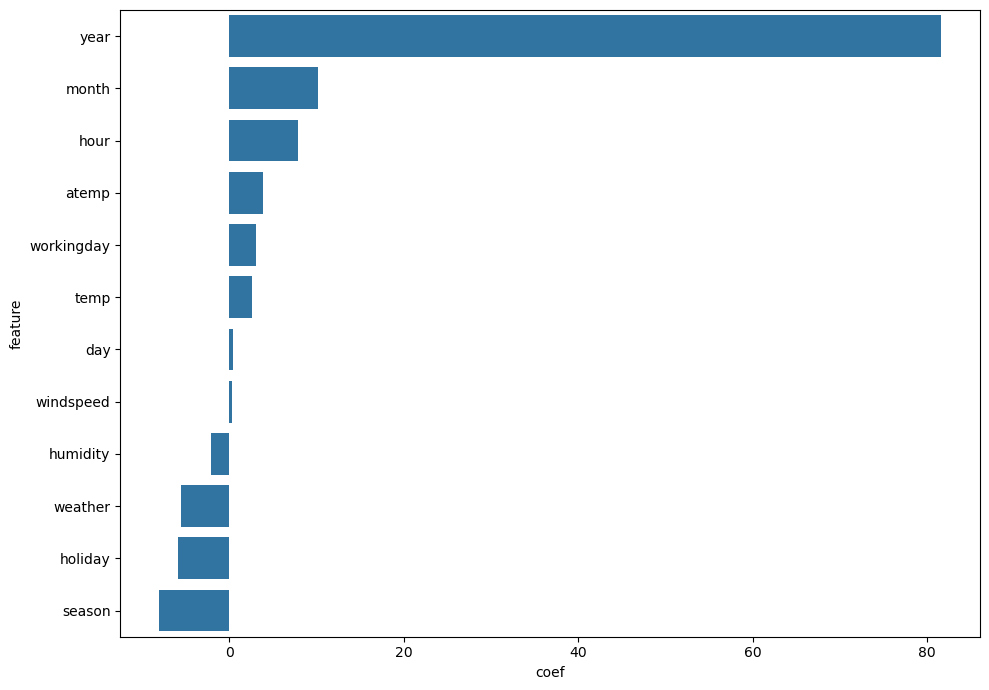

In [62]:
reg_coef_plot(lr, x.columns)

### (2) 타깃 변수 로그 변환 후 모델 학습/예측/평가

**타깃변수 로그변환**

In [9]:
x = bike2.drop('count', axis=1)
y = bike2['count']
lr_log = LinearRegression()
log_y = np.log1p(y)

**타깃 변수 로그변환 후 선형회귀 모델 학습/예측/평가(2)**

In [10]:
rmse_log, avg_rmse_log = fittormse(x,log_y,lr_log)

-- LinearRegression 의 5폴드 교차검증 --
RMSE: [1.057 0.937 1.079 1.041 1.009], AVG_RMSE: 1.025


=> RMSE: [1.057 0.937 1.079 1.041 1.009], AVG_RMSE: 1.025

**회귀계수 시각화**

회귀계수:
year          0.419
hour          0.098
month         0.077
atemp         0.031
temp          0.012
windspeed     0.004
day           0.003
weather      -0.015
humidity     -0.015
season       -0.045
holiday      -0.046
workingday   -0.066
dtype: float64


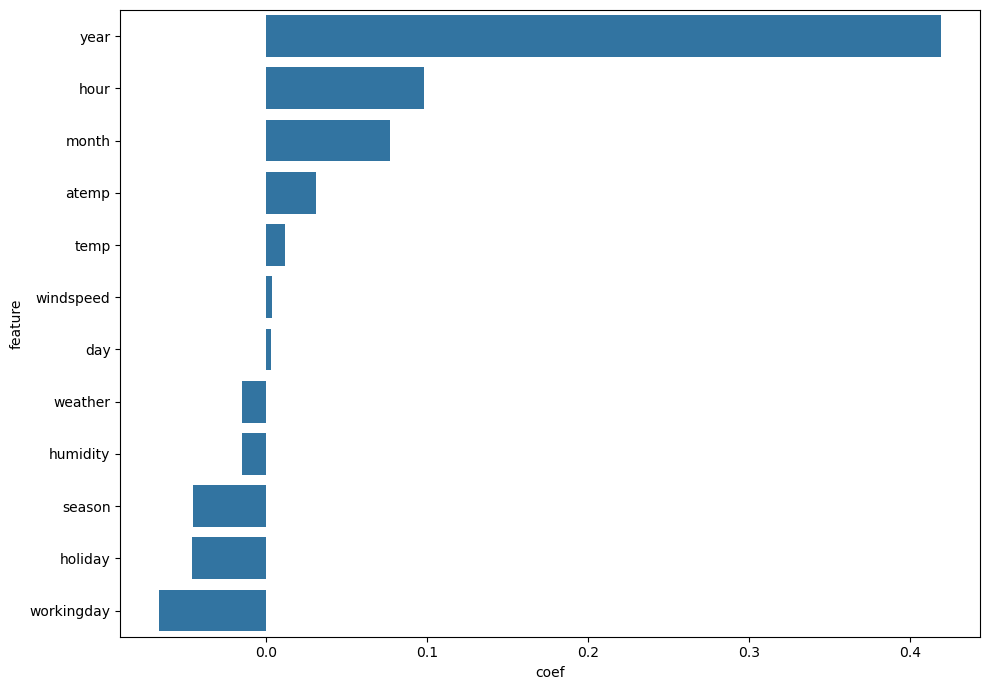

In [12]:
reg_coef_plot(lr_log, x.columns)

### (3) 피처 인코딩 후 모델 학습/예측/평가

**'year', month', 'day', hour' 피처 원-핫 인코딩**

In [13]:
bike2_one = pd.get_dummies(bike2, columns=['year', 'month', 'day', 'hour'], dtype='int')
bike2_one.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year_2011,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,0,0,1,9.84,14.395,81,0.0,16,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,9.02,13.635,80,0.0,40,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,9.02,13.635,80,0.0,32,1,...,0,0,0,0,0,0,0,0,0,0


**원-핫 인코딩 적용된 피처 데이터 기반으로 학습/예측/평가**

In [14]:
x = bike2_one.drop('count', axis=1)
y = bike2_one['count']
lr_one = LinearRegression()
log_one_y = np.log1p(y)

In [15]:
rmse_one, avg_rmse_one = fittormse(x,y,lr_one)

-- LinearRegression 의 5폴드 교차검증 --
RMSE: [ 98.347  84.462  85.973 128.521 131.831], AVG_RMSE: 105.827


=> RMSE: [ 98.347  84.462  85.973 128.521 131.831], AVG_RMSE: 105.827

In [16]:
lr_log_one = LinearRegression()
rmse_log_one, avg_rmse_log_one = fittormse(x,log_one_y,lr_log_one)

-- LinearRegression 의 5폴드 교차검증 --
RMSE: [0.674 0.606 0.652 0.59  0.58 ], AVG_RMSE: 0.62


=> RMSE: [0.674 0.606 0.652 0.59  0.58 ], AVG_RMSE: 0.62

**회귀계수 시각화**

회귀계수:
hour_17    261.366
hour_18    227.083
hour_8     193.952
hour_19    113.797
hour_16     99.616
            ...   
hour_1    -145.616
hour_5    -148.779
hour_2    -158.950
hour_3    -165.682
hour_4    -167.874
Length: 65, dtype: float64


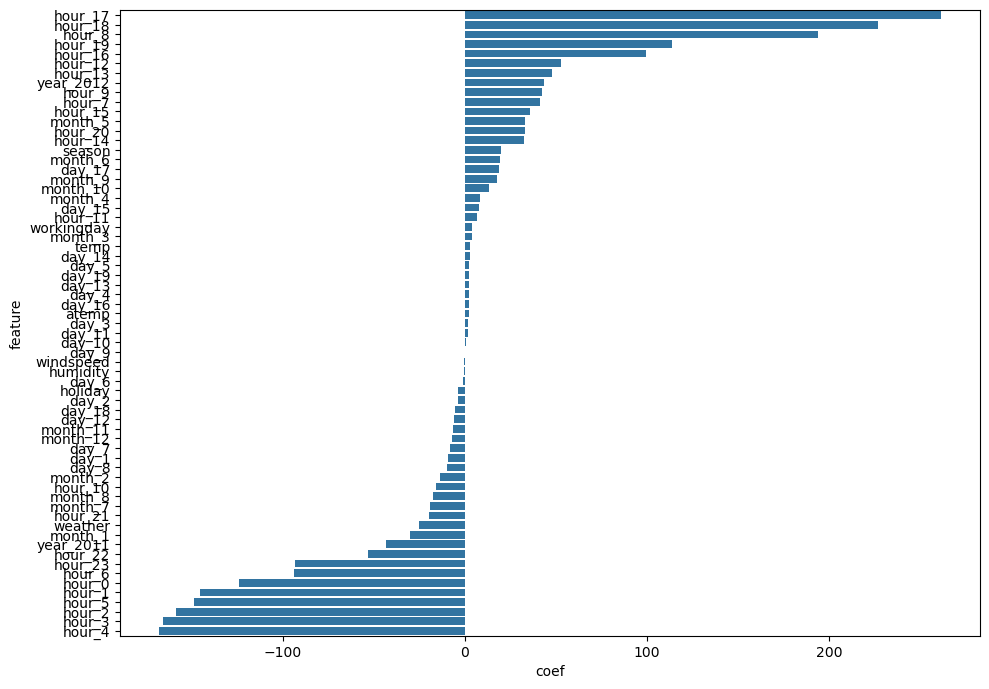

In [17]:
reg_coef_plot(lr_one, x.columns)

회귀계수:
hour_17    1.344
hour_18    1.253
hour_8     1.091
hour_19    0.963
hour_16    0.920
           ...  
hour_1    -1.390
hour_5    -1.729
hour_2    -1.936
hour_3    -2.388
hour_4    -2.678
Length: 65, dtype: float64


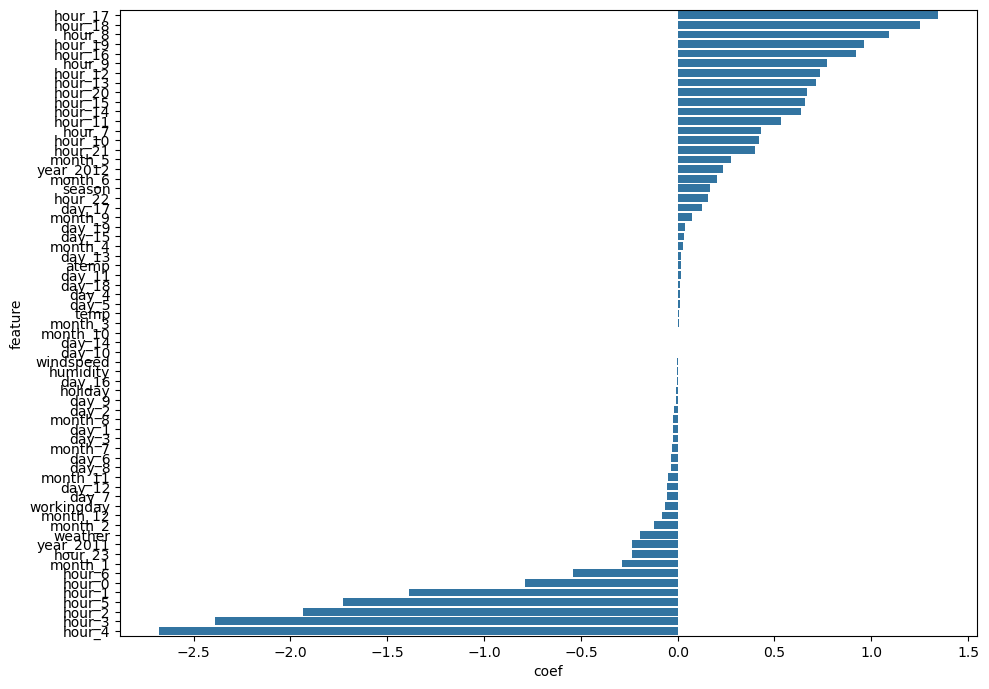

In [18]:
reg_coef_plot(lr_log_one, x.columns)

### 회귀트리를 이용한 예측

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [20]:
# 원핫인코딩 후 로그변환 데이터
x = bike2_one.drop('count', axis=1)
y = bike2_one['count']
log_one_y = np.log1p(y)

In [21]:
dt = DecisionTreeRegressor(max_depth= 4, random_state=0)
rf = RandomForestRegressor(n_estimators= 1000, random_state= 0)
gb = GradientBoostingRegressor(n_estimators=1000, random_state= 0)
xgb = XGBRegressor(n_estimators= 1000)
lgb = LGBMRegressor(n_estimators= 1000)


scores_df = pd.DataFrame()

for model in [dt, rf, gb, xgb, lgb]:
    rmse, avg_rmse = reg_model_cv_training(model,x,log_one_y)
    model_name = model.__class__.__name__
    score = pd.Series({'rmse': rmse, 'avg_rmse': avg_rmse})
    scores_df[model_name] = score

scores_df

-- DecisionTreeRegressor 의 5폴드 교차검증 --
RMSE: [1.305 0.831 0.954 0.988 0.988], AVG_RMSE: 1.013
-- RandomForestRegressor 의 5폴드 교차검증 --
RMSE: [0.716 0.393 0.452 0.388 0.425], AVG_RMSE: 0.475
-- GradientBoostingRegressor 의 5폴드 교차검증 --
RMSE: [0.658 0.346 0.398 0.349 0.376], AVG_RMSE: 0.425
-- XGBRegressor 의 5폴드 교차검증 --
RMSE: [0.732 0.361 0.497 0.411 0.412], AVG_RMSE: 0.483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 65
[LightGBM] [Info] Start training from score 4.753723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of da

,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor,LGBMRegressor
rmse,"[1.3049576213036445, 0.8305219792917474, 0.954...","[0.716034446271138, 0.39251744439003844, 0.452...","[0.6576252998351558, 0.34551795658099077, 0.39...","[0.7321525868889585, 0.3608782361426328, 0.496...","[0.6879243978862282, 0.35311639000162504, 0.41..."
avg_rmse,1.013112,0.474713,0.425152,0.482536,0.440918


|모델|RMSE|AVG_RMSE|
|---|---|---:|
|LinearRegression|[103.139 121.433 116.11 181.353 183.959]|141.199|
|LinearRegression: log변환|[1.057 0.937 1.079 1.041 1.009]|1.025|
|LinearRegression: 원핫인코딩|[ 98.347  84.462  85.973 128.521 131.831]|105.827|
|LinearRegression: log변환, 원핫인코딩|[0.674 0.606 0.652 0.59 0.58 ]|0.62|
|DecisionTreeRegressor|[1.305 0.831 0.954 0.988 0.988]|1.013|
|RandomForestRegressor|[0.716 0.393 0.452 0.388 0.425]|0.475|
|GradientBoostingRegressor|[0.658 0.346 0.398 0.349 0.376]|0.425|
|XGBRegressor|[0.732 0.361 0.497 0.411 0.412]|0.483|
|LGBMRegressor|[0.688 0.353 0.413 0.368 0.383]|0.441|

------